# Predicting Delta for Arbitrary Strike Prices

Using polygon.io for index options data.

This will be used for the purposes of gauging probability of a price close within a certain price range or outside of a upper/lower bound given some arbitrary price ranges.

This notebook will explore accuracy of different regression models for this task. Strike-Delta does not follow a linear relationship, so various non-linear regression methods will be used.

## Gathering options data

In [1]:
# imports
from polygon import RESTClient
from credentials import POLYGON_API_KEY
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# docs
# https://polygon.io/docs/options/get_v3_snapshot_options__underlyingasset___optioncontract
# https://polygon-api-client.readthedocs.io/en/latest/Snapshot.html

# client = RESTClient("XXXXXX") # hardcoded api_key is used
client = RESTClient(api_key=POLYGON_API_KEY)  # POLYGON_API_KEY environment variable is used

In [3]:
# Get options chain

underlying = "SPX"
today = datetime.today().strftime("%Y-%m-%d")
today = "2023-08-25"

snapshot = client.get_snapshot_option("I:SPX", "O:SPXW230825P04500000")

# print raw values
print(snapshot)

OptionContractSnapshot(break_even_price=None, day=DayOptionContractSnapshot(change=-10.6, change_percent=-16, close=55.5, high=55.5, last_updated=1692835200000000000, low=55.5, open=55.5, previous_close=66.13, volume=1, vwap=55.5), details=OptionDetails(contract_type='put', exercise_style='european', expiration_date='2023-08-25', shares_per_contract=100, strike_price=4500, ticker='O:SPXW230825P04500000'), greeks=Greeks(delta=-0.8730630493167926, gamma=0.004246431010089196, theta=-3.098100860010889, vega=0.5041198775087287), implied_volatility=0.1788042297630281, last_quote=LastQuoteOptionContractSnapshot(ask=60.5, ask_size=23, bid=59.4, bid_size=46, last_updated=1692884596852233216, midpoint=59.95, timeframe='REAL-TIME'), last_trade=LastTradeOptionContractSnapshot(price=55.5, sip_timestamp=1692884216298891776, size=1, conditions=[232], exchange=302, timeframe='REAL-TIME'), open_interest=5634, underlying_asset=UnderlyingAsset(change_to_break_even=None, last_updated=1680814651655000000, 

In [4]:
def build_options_data(underlying, today):

    data = {'call': [], 'put': []}

    for c in client.list_snapshot_options_chain(underlying_asset=underlying, params={"expiration_date": today}):
        if c.greeks.delta == None or c.implied_volatility == None:
            continue
        data[c.details.contract_type].append({'ticker': c.details.ticker, 'iv': c.implied_volatility, 'delta': c.greeks.delta, 'expiration_date': c.details.expiration_date, 'strike_price': c.details.strike_price})
    
    return data

data = build_options_data(underlying="I:SPX", today=today)

In [5]:
from opm import OPM

OPM = OPM(options_chain=data)

In [6]:
delta = OPM.predict_delta(4500)
delta

0.15917271325025492

In [7]:
details = OPM.get_delta_model_info()
details

{'MSE': 0.0008900879628800173, 'RMSE': 0.02983434200514597}

In [8]:
iv = OPM.predict_iv(4500)
iv

0.17905473730823473

In [9]:
import numpy as np
atm_strike = OPM.strikes[np.argmin(OPM.ivs)]
atm_strike

4520

In [10]:
print(OPM.get_iv_model_info())

{'MSE_near': 7.386272975593535e-05, 'MSE_other': 0.00010518642822521271}


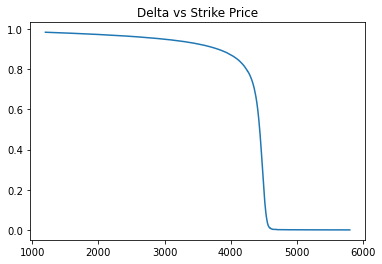

In [5]:
# Plotting
strikes = [x['strike_price'] for x in data['call']]
deltas = [x['delta'] for x in data['call']]
plt.plot(strikes, deltas)
plt.title("Delta vs Strike Price")
plt.show()

## Polynomial Regression

In [6]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [7]:
# init data
X = np.array(strikes).reshape(-1, 1)
y = deltas

# partition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# train

degree = 4

# Transform data to polynomial features
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Fit the model
regressor = LinearRegression()
regressor.fit(X_poly, y_train)

LinearRegression()

Mean Squared Error: 0.02367162735507198
Root Mean Squared Error: 0.15385586552053185


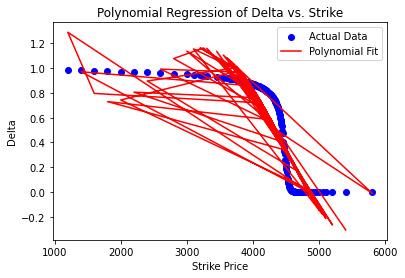

In [15]:
# evaluate

# Predict on test set
y_pred = regressor.predict(X_poly_test)

# Calculate and print MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

# Plot the results
plt.scatter(X_train, y_train, color='blue', label='Actual Data')
plt.plot(X_train, regressor.predict(X_poly), color='red', label='Polynomial Fit')
plt.title('Polynomial Regression of Delta vs. Strike')
plt.xlabel('Strike Price')
plt.ylabel('Delta')
plt.legend()
plt.show()

# Piecewise Polynomial Regression

In [57]:
# data

strikes = np.array([x['strike_price'] for x in data['call']])
ivs = np.array([x['delta'] for x in data['call']])

In [43]:
# Define the 'near-the-money' region
at_the_money_strike = 4450  # i would assume arg_strike for min iv?
bandwidth = int(at_the_money_strike * .1)  # 5% around atm

near_the_money_mask = np.abs(strikes - at_the_money_strike) < bandwidth
X_near = strikes[near_the_money_mask].reshape(-1, 1)
y_near = ivs[near_the_money_mask]

X_other = strikes[~near_the_money_mask].reshape(-1, 1)
y_other = ivs[~near_the_money_mask]

In [44]:
# Define polynomial degree for each region
degree_near = 5

# Fit polynomial regression for near-the-money data
poly_near = PolynomialFeatures(degree=degree_near)
X_poly_near = poly_near.fit_transform(X_near)
regressor_near = LinearRegression().fit(X_poly_near, y_near)

In [45]:
degree_other = 2

# Fit polynomial regression for other data
poly_other = PolynomialFeatures(degree=degree_other)
X_poly_other = poly_other.fit_transform(X_other)
regressor_other = LinearRegression().fit(X_poly_other, y_other)

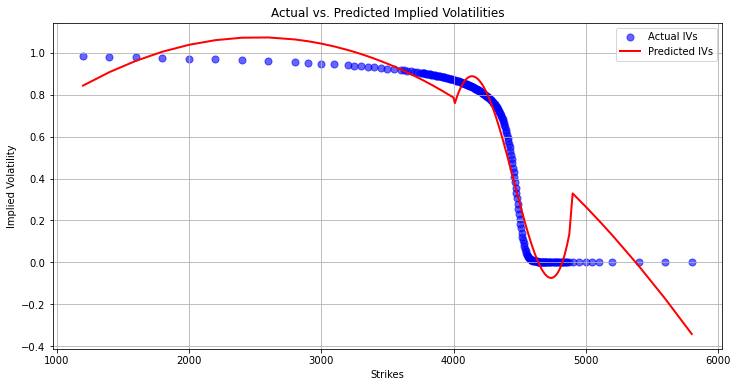

In [46]:
# Prediction function
def predict_iv(strike):
    if np.abs(strike - at_the_money_strike) < bandwidth:
        x_poly = poly_near.transform([[strike]])
        return regressor_near.predict(x_poly)[0]
    else:
        x_poly = poly_other.transform([[strike]])
        return regressor_other.predict(x_poly)[0]

# Predict across all strikes
predicted_ivs = [predict_iv(strike) for strike in strikes]

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(strikes, ivs, color='blue', label='Actual IVs', s=50, alpha=0.6)
plt.plot(strikes, predicted_ivs, color='red', label='Predicted IVs', linewidth=2)
plt.xlabel('Strikes')
plt.ylabel('Implied Volatility')
plt.title('Actual vs. Predicted Implied Volatilities')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Predictions for near-the-money and other data
predicted_ivs_near = regressor_near.predict(poly_near.transform(X_near))
predicted_ivs_other = regressor_other.predict(poly_other.transform(X_other))

# Calculate MSE for both regions
mse_near = mean_squared_error(y_near, predicted_ivs_near)
mse_other = mean_squared_error(y_other, predicted_ivs_other)

# Calculate overall MSE
predicted_ivs_all = np.concatenate((predicted_ivs_near, predicted_ivs_other))
y_all = np.concatenate((y_near, y_other))
mse_overall = mean_squared_error(y_all, predicted_ivs_all)

print(f"MSE for Near-the-money model: {mse_near}")
print(f"MSE for Other model: {mse_other}")
print(f"Overall MSE: {mse_overall}")

MSE for Near-the-money model: 0.021500579148141002
MSE for Other model: 0.004549680153334226
Overall MSE: 0.018816047633126356


Predicted Delta for strike 2500: 0.9999890142676713


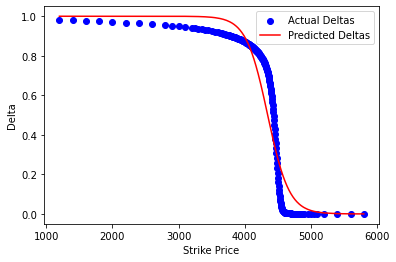

In [59]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Modify deltas to ensure they're strictly between 0 and 1
epsilon = 0.001
deltas_modified = np.clip(deltas, epsilon, 1-epsilon)

# Add a constant (intercept) to the predictors
X = sm.add_constant(strikes)

# Create a GLM model with a binomial family (logistic link function)
model = sm.GLM(deltas_modified, X, family=sm.families.Binomial())
result = model.fit()

# Predict for new data
def predict_delta(strike):
    x_new = np.array([[1, strike]])  # 1 is for the intercept
    return result.predict(x_new)[0]

# Test it on an arbitrary strike price
arbitrary_strike = 2500  # replace with your value
predicted_delta = predict_delta(arbitrary_strike)
print(f"Predicted Delta for strike {arbitrary_strike}: {predicted_delta}")

# Optional: Visualizing the relationship
plt.scatter(strikes, deltas, label='Actual Deltas', color='blue')
plt.plot(strikes, [predict_delta(s) for s in strikes], label='Predicted Deltas', color='red')
plt.xlabel('Strike Price')
plt.ylabel('Delta')
plt.legend()
plt.show()


Predicted Delta for strike 4500: [0.22723662]


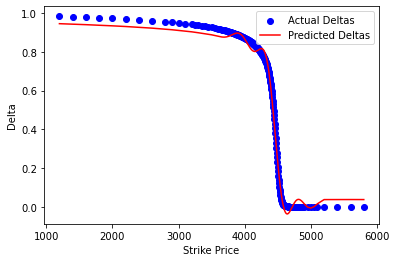

Mean Squared Error: 0.0007669203741120699
Root Mean Squared Error: 0.027693327248853105


In [28]:
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

strikes = np.array([x['strike_price'] for x in data['call']])
deltas = np.array([x['delta'] for x in data['call']])

# Scaling the data can often improve performance with SVR
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X = scaler_X.fit_transform(strikes.reshape(-1, 1))
y = scaler_Y.fit_transform(deltas.reshape(-1, 1))

# Create and fit the SVR model
svr = SVR(kernel='rbf', C=1e3, gamma=5)
svr.fit(X, y.ravel())

# Predict for new data
def predict_delta(strike):
    x = scaler_X.transform(np.array(strike).reshape(-1, 1))
    y_pred = svr.predict(x)
    return scaler_Y.inverse_transform(y_pred.reshape(-1, 1))[0]

# Test on an arbitrary strike price
arbitrary_strike = 4500  # replace with your value
predicted_delta = predict_delta(arbitrary_strike)
print(f"Predicted Delta for strike {arbitrary_strike}: {predicted_delta}")

# Optional: Visualizing the relationship
plt.scatter(strikes, deltas, label='Actual Deltas', color='blue')
plt.plot(strikes, [predict_delta(s) for s in strikes], label='Predicted Deltas', color='red')
plt.xlabel('Strike Price')
plt.ylabel('Delta')
plt.legend()
plt.show()

# Calculate and print the MSE
predicted_deltas = [predict_delta(s) for s in strikes]
mse = mean_squared_error(deltas, predicted_deltas)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")